# MNIST

First I download the dataset from https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz and upload it onto colab instance (wget seems to corrupt the files)



Then I replicate code from http://neuralnetworksanddeeplearning.com/chap1.html

In [ ]:
"""
mnist_loader
~~~~~~~~~~~~

A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import pickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    # f = gzip.open('../data/mnist.pkl.gz', 'rb')
    f = gzip.open('../mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [one_hot_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def one_hot_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [ ]:
tr_d, va_d, te_d = load_data()
print(type(tr_d))
print(len(tr_d))
print(type(tr_d[0]))
print(tr_d[0].shape, tr_d[1].shape, te_d[0].shape, te_d[1].shape)

<class 'tuple'>
2
<class 'numpy.ndarray'>
(50000, 784) (50000,) (10000, 784) (10000,)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: 
            test_data = list(test_data)
            n_test = len(test_data)
        
        training_data = list(training_data)
        n = len(training_data)

        for j in range(epochs):
            # shuffle the training data every time
            random.shuffle(training_data)
            # create minibatches of given size
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            # update minibatch using backpropagation
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)



            if test_data:
                print("Epoch {}: {} / {}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]


        # create X and Y lists that are going to contain vectors from a minibatch.
        # X list contains all the x (input) vectors from the pairs in the minibatch
        # Y list contains all the y (label) vectors from the pairs in the minibatch
        X = [pair[0] for pair in mini_batch]
        Y = [pair[1] for pair in mini_batch]

        # In this solution we are passing "the whole minibatch" instead of just one pair from 
        # the minibatch into the backpropagation function
        nabla_b, nabla_w = self.backprop(X,Y)


        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, X, Y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # Create the np array the same size as biases and weights that are
        # going to contain the updated nabla_b and unpdated nabla_w 
        total_nabla_b = [np.zeros(b.shape) for b in self.biases]
        total_nabla_w = [np.zeros(b.shape) for b in self.weights]

        # iterate over an element from X and Y paralely at the same time using zip
        for column_X, column_Y in zip(X,Y):

          activation = column_X # take first column of the X
          activations = [column_X] # list to store all the activations, layer by layer

          zs = [] # list to store all the z vectors, layer by layer

          # feedforward
          for b, w in zip(self.biases, self.weights):
              z = np.dot(w, activation)+b
              zs.append(z)
              activation = sigmoid(z)
              activations.append(activation)

          # Calculate the error in the last layer
          delta = self.cost_derivative(activations[-1], column_Y) * \
              sigmoid_prime(zs[-1])

          # change in biases with respect to cost is equal to the change in the last layer
          nabla_b[-1] = delta
          nabla_w[-1] = np.dot(delta, activations[-2].transpose())
          # Note that the variable l in the loop below is used a little
          # differently to the notation in Chapter 2 of the book.  Here,
          # l = 1 means the last layer of neurons, l = 2 is the
          # second-last layer, and so on.  It's a renumbering of the
          # scheme in the book, used here to take advantage of the fact
          # that Python can use negative indices in lists.

          # back pass
          for l in range(2, self.num_layers):
              z = zs[-l]
              sp = sigmoid_prime(z)
              delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
              nabla_b[-l] = delta
              nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

          # update the weights and biases
          total_nabla_b = [nb+dnb for nb, dnb in zip(total_nabla_b, nabla_b)]
          total_nabla_w = [nw+dnw for nw, dnw in zip(total_nabla_w, nabla_w)]

        return (total_nabla_b, total_nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network k's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [ ]:
tr, v, te = load_data_wrapper()
net = Network([784, 30, 10]) 

In [ ]:
net.SGD(tr, 30, 10, 3.0, test_data=te)

Epoch 0: 9135 / 10000
Epoch 1: 9269 / 10000
Epoch 2: 9299 / 10000
Epoch 3: 9351 / 10000
Epoch 4: 9386 / 10000
Epoch 5: 9398 / 10000
Epoch 6: 9444 / 10000
Epoch 7: 9417 / 10000
Epoch 8: 9466 / 10000
Epoch 9: 9470 / 10000
Epoch 10: 9484 / 10000
Epoch 11: 9466 / 10000
Epoch 12: 9462 / 10000
Epoch 13: 9497 / 10000
Epoch 14: 9407 / 10000
Epoch 15: 9496 / 10000
Epoch 16: 9511 / 10000
Epoch 17: 9521 / 10000
Epoch 18: 9524 / 10000
Epoch 19: 9494 / 10000
Epoch 20: 9507 / 10000
Epoch 21: 9546 / 10000
Epoch 22: 9516 / 10000
Epoch 23: 9514 / 10000
Epoch 24: 9545 / 10000
Epoch 25: 9509 / 10000
Epoch 26: 9523 / 10000
Epoch 27: 9517 / 10000
Epoch 28: 9501 / 10000
Epoch 29: 9535 / 10000


In [ ]:
tr, v, te = load_data_wrapper()

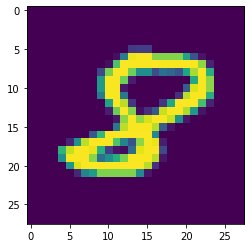

predicted: 2 actual: 8


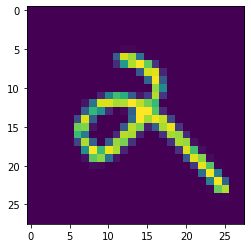

predicted: 9 actual: 2


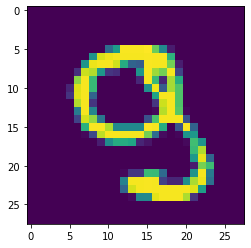

predicted: 8 actual: 9


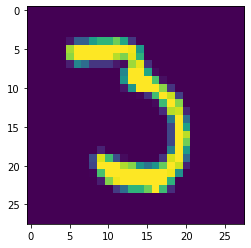

predicted: 2 actual: 3


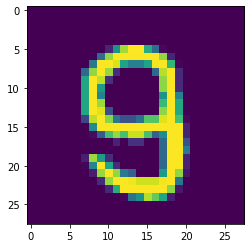

predicted: 8 actual: 9


In [ ]:
upto = 5
for img, lab in te:
    pred = net.feedforward(img)
    pred_lab = np.argmax(pred)
    if pred_lab != lab:
        plt.imshow(img.reshape((28, 28)))
        plt.show()
        print("predicted:", pred_lab, "actual:", lab)
        upto -= 1
    if upto < 1: break

## Now use keras

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 10
# input_shape = (28, 28, 1)
input_shape = (28 * 28, )


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)

# Make sure images have shape (28 * 28, 1)
x_train = x_train.reshape((-1, 28 * 28))
x_test = x_test.reshape((-1, 28 * 28))
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11501568/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 784)
60000 train samples
10000 test samples


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(30, activation="sigmoid"), # 30 hidden neurons
        layers.Dense(10, activation="softmax"), # 10 output neurons, 1 for each class
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 30)                23550     
                                                                 
 dense_3 (Dense)             (None, 10)                310       
                                                                 
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss=keras.losses.MeanSquaredError(reduction=keras.losses.Reduction.SUM), 
    optimizer=keras.optimizers.SGD(learning_rate=3), 
    metrics=[keras.metrics.CategoricalAccuracy()]
)
# Default reduction is average over dims followed by average over batch size
# see Scratch section

model.fit(
    x_train, y_train, batch_size=10, epochs=30, validation_split=0.1
)

Epoch 1/30
5400/5400 [==============================] - 11s 2ms/step - loss: 0.1690 - categorical_accuracy: 0.8878 - val_loss: 0.1235 - val_categorical_accuracy: 0.9218
Epoch 2/30
5400/5400 [==============================] - 10s 2ms/step - loss: 0.1239 - categorical_accuracy: 0.9212 - val_loss: 0.0869 - val_categorical_accuracy: 0.9458
Epoch 3/30
5400/5400 [==============================] - 10s 2ms/step - loss: 0.1142 - categorical_accuracy: 0.9275 - val_loss: 0.0907 - val_categorical_accuracy: 0.9433
Epoch 4/30
5400/5400 [==============================] - 10s 2ms/step - loss: 0.1107 - categorical_accuracy: 0.9310 - val_loss: 0.0843 - val_categorical_accuracy: 0.9477
Epoch 5/30
5400/5400 [==============================] - 12s 2ms/step - loss: 0.1011 - categorical_accuracy: 0.9365 - val_loss: 0.0810 - val_categorical_accuracy: 0.9503
Epoch 6/30
5400/5400 [==============================] - 10s 2ms/step - loss: 0.1015 - categorical_accuracy: 0.9367 - val_loss: 0.0771 - val_categorical_acc

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2533735930919647
Test accuracy: 0.9520999789237976


# Scratch

In [ ]:
upto = 2
for img, lab in te:
    print(img.shape, lab.shape)
    upto -= 1
    if upto < 1: break

(784, 1) ()
(784, 1) ()


In [ ]:
upto = 2
for img, lab in te:
    pred = net.feedforward(img)
    print(pred, lab)
    upto -= 1
    if upto < 1: break

[[9.94852847e-16]
 [9.99287714e-01]
 [2.78055426e-08]
 [3.83721098e-06]
 [3.54855330e-06]
 [1.76447776e-10]
 [6.69120469e-05]
 [3.00309416e-03]
 [7.69461463e-07]
 [9.79708934e-07]] 1
[[9.95514280e-01]
 [2.24533820e-05]
 [2.34155561e-07]
 [2.71358388e-07]
 [4.68065814e-04]
 [2.79598157e-07]
 [1.26880537e-04]
 [6.04709061e-08]
 [6.76297748e-08]
 [5.61063683e-05]] 0


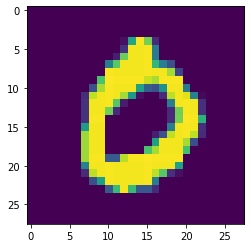

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img.reshape((28, 28)))

In [ ]:
upto = 2
for img, lab in te:
    pred = net.feedforward(img)
    pred_lab = np.argmax(pred)
    print(pred_lab, lab)
    upto -= 1
    if upto < 1: break

4 4
1 1


In [ ]:
upto = 1
z = zip([1, 2], [4, 5])
for x, y in z:
    print(x, y)
    upto -= 1
    if upto < 1: break

1 4


In [ ]:
y = list(z)
y

[(2, 5)]

In [ ]:
'''
For some reason this results in corrupted files
'''

#!wget https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz 
#!wget https://github.com/MichalDanielDobrzanski/DeepLearningPython/blob/master/mnist.pkl.gz 

In [ ]:
pred = np.argmax(model(x_test), axis=1)
true = np.argmax(y_test, axis=1)

In [ ]:
# y_test[:2]
sum(pred == true) / len(y_test)
# m = keras.metrics.Accuracy()
# m.update_state(np.expand_dims(pred, axis=1), np.expand_dims(true, axis=1))
# m.result().numpy()

0.1151

In [ ]:
# np.expand_dims(pred, axis=1)[:3]
# pred[:3]
print(y_test[:3])
model(x_test[:3])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[0.02702972, 0.1902639 , 0.05914813, 0.05440875, 0.09455995,
        0.17240931, 0.03179046, 0.12296242, 0.11256479, 0.13486259],
       [0.02055437, 0.18911885, 0.05087472, 0.05972384, 0.09683575,
        0.17117271, 0.03097234, 0.14020933, 0.11615209, 0.12438594],
       [0.02596499, 0.19241272, 0.05001093, 0.06918433, 0.09283505,
        0.19412108, 0.02545374, 0.12864646, 0.10250535, 0.11886541]],
      dtype=float32)>

In [ ]:
m = keras.metrics.CategoricalAccuracy()
m.update_state(model(x_test[:9]), y_test[:9])
m.result().numpy()

0.22222222

In [ ]:
print(true[:9])
print(pred[:9])

[7 2 1 0 4 1 4 9 5]
[1 1 5 5 5 1 5 1 5]


In [ ]:
# model(x_test[:9]).numpy()
y_test[:9]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
mse = keras.losses.MeanSquaredError()
mse(y_train[:2], model(x_train[:2]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0016072472>

In [ ]:
y_true = [[0.3, 1.], [0., 0.]]
y_pred = [[1., 1.], [1., 0.99]]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = keras.losses.MeanSquaredError(reduction=keras.losses.Reduction.SUM)
mse(y_true, y_pred).numpy()

1.23505

In [ ]:
np.square(np.array(y_true) - np.array(y_pred))

array([[0.49  , 0.    ],
       [1.    , 0.9801]])

In [ ]:
# np.average(np.square(np.array(y_true) - np.array(y_pred)), axis=1)
np.sum(np.square(np.array(y_true) - np.array(y_pred)), axis=1)

array([0.49  , 1.9801])

In [ ]:
# np.average(np.average(np.square(np.array(y_true) - np.array(y_pred)), axis=1))
np.average(np.sum(np.square(np.array(y_true) - np.array(y_pred)), axis=1))

1.23505